In [1]:
import sys
import os
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from optimizers.IPS import IPS
from optimizers.AdaIPS_v2 import AdaIPS_S
from utils.getData import getData

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [4]:
epochs = 10
batch_size = 64


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('FashionMNIST', transform=transform, batch_size=batch_size)

In [6]:
def train(model, optimizer, epochs=2):
    model.train()
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            running_loss += loss
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
        
        # model.t_losses.append(running_loss / len(trainloader.dataset))
            

    print("Training complete.")
    return model

In [7]:
def test(model):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print(np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(accuracy_score(labels, output.detach().numpy()))
        print(precision, recall, fscore)
        

        precision, recall, fscore, support = precision_recall_fscore_support(labels, output, average=None)

        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [8]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False
AdaIPS_S (
Parameter Group 0
    T0: 7500.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.321471929550171
Epoch 1, Step 100, Loss: 0.9926338791847229
Epoch 1, Step 200, Loss: 0.6093659996986389
Epoch 1, Step 300, Loss: 0.4043467938899994
Epoch 1, Step 400, Loss: 0.6774854063987732
Epoch 1, Step 500, Loss: 0.40999743342399597
Epoch 1, Step 600, Loss: 0.5855444669723511
Epoch 1, Step 700, Loss: 0.5002408027648926
Epoch 2, Step 0, Loss: 0.42832842469215393
Epoch 2, Step 100, Loss: 0.39089956879615784
Epoch 2, Step 200, Loss: 0.32467490434646606
Epoch 2, Step 300, Loss: 0.36627334356307983
Epoch 2, Step 400, Loss: 0.3183700442314148
Epoch 2, Step 500, Loss: 0.6327594518661499
Epoch 2, Step 600, Loss: 0.31163543462753296
Epoch 2, Step 700, Loss: 0.42656782269477844
Epoch 3, Step 0, Loss: 0.3506229519844055
Epoch 3, Step 100, Loss: 0.37989670038223267
Epoch 3, Step 200, Loss: 0.381655365

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [9]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 7500.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.308295965194702
Epoch 1, Step 100, Loss: 1.0199217796325684
Epoch 1, Step 200, Loss: 0.7366704940795898
Epoch 1, Step 300, Loss: 0.659162700176239
Epoch 1, Step 400, Loss: 0.6694032549858093
Epoch 1, Step 500, Loss: 0.7544957399368286
Epoch 1, Step 600, Loss: 0.7002007961273193
Epoch 1, Step 700, Loss: 0.691005527973175
Epoch 2, Step 0, Loss: 0.5064210295677185
Epoch 2, Step 100, Loss: 0.5553712248802185
Epoch 2, Step 200, Loss: 0.626480221748352
Epoch 2, Step 300, Loss: 0.493134081363678
Epoch 2, Step 400, Loss: 0.5286682844161987
Epoch 2, Step 500, Loss: 0.5617207884788513
Epoch 2, Step 600, Loss: 0.6012498736381531
Epoch 2, Step 700, Loss: 0.7134639620780945
Epoch 3, Step 0, Loss: 0.6765497922897339
Epoch 3, Step 100, Loss: 0.6210170388221741
Epoch 3, Step 200, Loss: 0.49486252665519714
Epoch 3, Step 300, Loss: 0.6035370826721191
Epoch 3, Step 400, Loss: 0.5989271402359009
Epoch 3, Step 500, Loss: 0.

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [10]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.316694736480713
Epoch 1, Step 100, Loss: 0.6190266013145447
Epoch 1, Step 200, Loss: 0.44857069849967957
Epoch 1, Step 300, Loss: 0.5383638739585876
Epoch 1, Step 400, Loss: 0.45619186758995056
Epoch 1, Step 500, Loss: 0.6078380346298218
Epoch 1, Step 600, Loss: 0.3574107885360718
Epoch 1, Step 700, Loss: 0.4513166546821594
Epoch 2, Step 0, Loss: 0.3322353959083557
Epoch 2, Step 100, Loss: 0.4750695526599884
Epoch 2, Step 200, Loss: 0.33825981616973877
Epoch 2, Step 300, Loss: 0.5295665264129639
Epoch 2, Step 400, Loss: 0.46231845021247864
Epoch 2, Step 500, Loss: 0.41989395022392273
Epoch 2, Step 600, Loss: 0.2548508644104004
Epoch 2, Step 700, Loss: 0.3163035213947296
Epoch 3, Step 0, Loss: 0.4292592704296112
Epoch 3, Step 100, Loss: 0.203396

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [11]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3311612606048584
Epoch 1, Step 100, Loss: 0.39637187123298645
Epoch 1, Step 200, Loss: 0.44067177176475525
Epoch 1, Step 300, Loss: 0.5710664391517639
Epoch 1, Step 400, Loss: 0.5121617317199707
Epoch 1, Step 500, Loss: 0.2963884770870209
Epoch 1, Step 600, Loss: 0.29190701246261597
Epoch 1, Step 700, Loss: 0.47560110688209534
Epoch 2, Step 0, Loss: 0.4142480492591858
Epoch 2, Step 100, Loss: 0.3523159921169281
Epoch 2, Step 200, Loss: 0.3802613914012909
Epoch 2, Step 300, Loss: 0.3040512502193451
Epoch 2, Step 400, Loss: 0.35372692346572876
Epoch 2, Step 500, Loss: 0.361949622631073
Epoch 2, Step 600, Loss: 0.37718087434768677
Epoch 2, Step 700, Loss: 0.3854634761810303
Epoch 3, Step 0, Loss: 0.4367735981941223
Epoch 3, Step 100, Loss: 0.309402048

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
test(adaIpsModel)
# test(ipsModel)
test(adamModel)
# test(rmsModel)

[0 1 2 3 4 5 6 7 8 9]
0.8682
0.8704055669474894 0.8682 0.8656178416018722
Class 0 -> Precision: 0.7795, Recall: 0.8730, F1-score: 0.8236
Class 1 -> Precision: 0.9702, Recall: 0.9780, F1-score: 0.9741
Class 2 -> Precision: 0.8141, Recall: 0.7050, F1-score: 0.7556
Class 3 -> Precision: 0.8863, Recall: 0.8730, F1-score: 0.8796
Class 4 -> Precision: 0.6882, Recall: 0.8960, F1-score: 0.7785
Class 5 -> Precision: 0.9674, Recall: 0.9510, F1-score: 0.9592
Class 6 -> Precision: 0.7287, Recall: 0.5290, F1-score: 0.6130
Class 7 -> Precision: 0.9226, Recall: 0.9660, F1-score: 0.9438
Class 8 -> Precision: 0.9826, Recall: 0.9620, F1-score: 0.9722
Class 9 -> Precision: 0.9644, Recall: 0.9490, F1-score: 0.9567
[0 1 2 3 4 5 6 7 8 9]
0.8845
0.8856306040722755 0.8845 0.8847150463783029
Class 0 -> Precision: 0.8510, Recall: 0.8280, F1-score: 0.8393
Class 1 -> Precision: 0.9888, Recall: 0.9690, F1-score: 0.9788
Class 2 -> Precision: 0.8012, Recall: 0.7820, F1-score: 0.7915
Class 3 -> Precision: 0.8588, Rec

[2.321471929550171, 0.9926338791847229, 0.6093659996986389, 0.4043467938899994, 0.6774854063987732, 0.40999743342399597, 0.5855444669723511, 0.5002408027648926, 0.42832842469215393, 0.39089956879615784, 0.32467490434646606, 0.36627334356307983, 0.3183700442314148, 0.6327594518661499, 0.31163543462753296, 0.42656782269477844, 0.3506229519844055, 0.37989670038223267, 0.38165536522865295, 0.2986963093280792, 0.4157659709453583, 0.4193519651889801, 0.3523258566856384, 0.35787996649742126, 0.2137686163187027, 0.2299787998199463, 0.5797172784805298, 0.24018248915672302, 0.2776365280151367, 0.2569497525691986, 0.434906929731369, 0.2964558005332947, 0.39503976702690125, 0.35889115929603577, 0.22632242739200592, 0.12862658500671387, 0.3332139849662781, 0.1765390783548355, 0.1822943240404129, 0.29824715852737427, 0.45040038228034973, 0.329124391078949, 0.28205105662345886, 0.3343845009803772, 0.32224687933921814, 0.30253836512565613, 0.35862997174263, 0.33809828758239746, 0.2769460678100586, 0.2

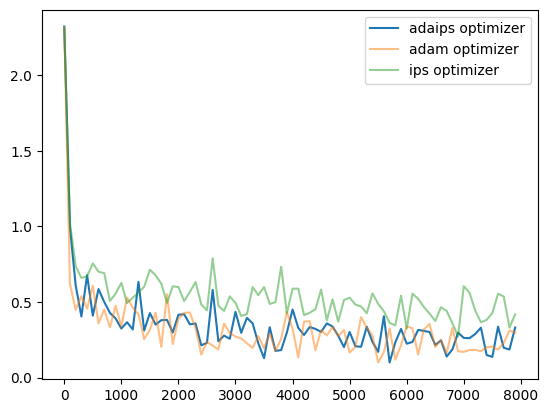

In [13]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    # (rmsModel, 'rmsprop optimizer'),
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    print(model.t_losses)
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

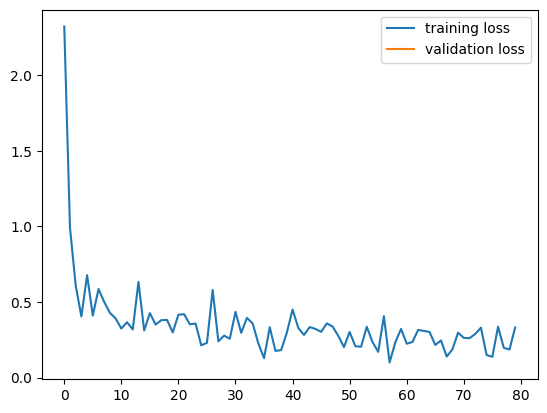

In [14]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
